/Users/yingliu/anaconda/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)
/Users/yingliu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


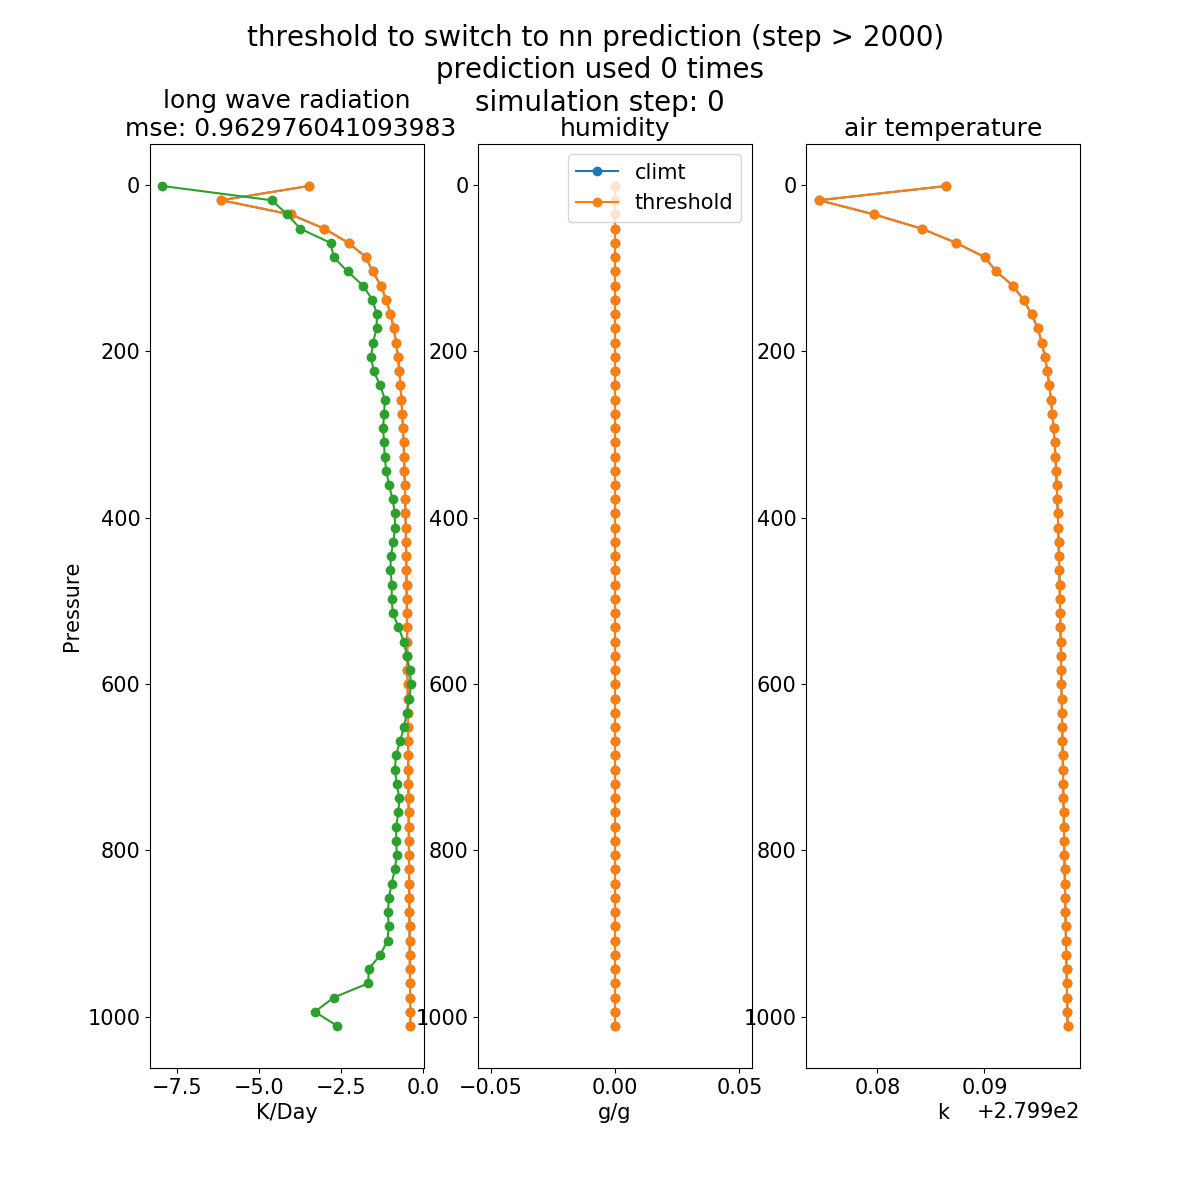

/Users/yingliu/anaconda/lib/python3.6/site-packages/sympl/_core/tendencystepper.py:148: UserWarning: Using an ImplicitTendencyComponent in sympl TendencyStepper objects may lead to scientifically invalid results. Make sure the component follows the same numerical assumptions as the TendencyStepper used.
  'Using an ImplicitTendencyComponent in sympl TendencyStepper objects may '


<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon
<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon
0
<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon
<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon
<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon
<xarray.DataArray (lon: 1)>
array([0.])
Dimensions without coordinates: lon


KeyboardInterrupt: 

In [1]:
# %load column_code_with_slab_60lvl.py
%matplotlib notebook
from sympl import (
    DataArray, PlotFunctionMonitor,
    AdamsBashforth)
from climt import SimplePhysics, get_default_state, get_grid
import numpy as np
from datetime import timedelta
from radnet import RadNet
import pickle
from scipy.interpolate import CubicSpline
from climt import EmanuelConvection, RRTMGShortwave, RRTMGLongwave, SlabSurface
# import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sympl import TendencyComponent
import json
import sympl
sympl.set_constant('stellar_irradiance', 700, 'W/m^2')

global state_mixed
global state_nn
global state_climt

global use_nn_counter

global climt_compare
global climt_compare_nn

global tmp_air_temperature_top

rcParams['figure.figsize'] = 12, 12
rcParams['font.size'] = 15

import os

path = os.path.dirname(os.getcwd())

radnet_new_climt = RadNet(path + '/graph-frozen-radnet-interpolate-on-pressure.pb')
#radnet_new_climt = RadNet(path + '/graph-frozen-radnet-3c1f-1ds.pb')

class NNRadiation(TendencyComponent):

        
    def array_call(self):
        return
    
    input_properties = RRTMGLongwave.input_properties
    tendency_properties = RRTMGLongwave.tendency_properties
    diagnostic_properties = RRTMGLongwave.diagnostic_properties
    
    global use_nn_counter

    use_nn_counter = 0
    
    
    _rrtmg = None
    
    def __getattr__(self, attr):
        return getattr(self._rrtmg, attr)
    
    def __init__(self):
        self._rrtmg = RRTMGLongwave()
        self.start_use_nn = False
        return
    
    def __call__(self, state):
        
        global climt_compare
        global use_nn_counter
        global mse    
        global simulation_step
        global tmp_air_temperature_top
        
        state['air_temperature'].values[-5:, 0, 0] = tmp_air_temperature_top
        
        tendencies, diagnostics = self._rrtmg(state)
        heating_rate = predict_radiation(radnet_new_climt, state)
        
        climt_compare = np.squeeze(tendencies['air_temperature'])
        
        mse = mean_squared_error(np.squeeze(tendencies['air_temperature']), heating_rate)
        
        #if (mse > 0.5 or simulation_step < 10) and not self.start_use_nn and simulation_step < :
        if simulation_step < 2000:
            #tendencies, diagnostics = self._rrtmg(state)
            state['longwave_heating_rate'] = tendencies['air_temperature']
            return tendencies, {}
        else:
            self.start_use_nn = True
            use_nn_counter = use_nn_counter + 1
            output_field = deepcopy(state['air_temperature'])
            output_field.attrs['units'] = 'degK/day'
            #heating_rate = predict_radiation(radnet_new_climt, state)
            output_field.values[:, 0, 0] = heating_rate
            tendencies = {}
            tendencies['air_temperature'] = output_field
            state['longwave_heating_rate'] = output_field
            return tendencies, {}


class ClimtRadiation(TendencyComponent):
        
    def array_call(self):
        return
    
    input_properties = RRTMGLongwave.input_properties
    tendency_properties = RRTMGLongwave.tendency_properties
    diagnostic_properties = RRTMGLongwave.diagnostic_properties
    
    _rrtmg = None
    
    def __getattr__(self, attr):
        return getattr(self._rrtmg, attr)
    
    def __init__(self):
        self._rrtmg = RRTMGLongwave()
        return
    
    def __call__(self, state):
        
        global tmp_air_temperature_top
        global climt_compare_nn
        
        climt_compare_nn = predict_radiation(radnet_new_climt, state)
        
        tmp_air_temperature_top = state['air_temperature'].values[-5:, 0, 0]
        tendencies, diagnostics = self._rrtmg(state)
        state['longwave_heating_rate'] = tendencies['air_temperature']
        return tendencies, {}
        
class NNRadiationOnly(TendencyComponent):
    
    def array_call(self):
        return
    
    input_properties = RRTMGLongwave.input_properties
    tendency_properties = RRTMGLongwave.tendency_properties
    diagnostic_properties = RRTMGLongwave.diagnostic_properties
    
    _rrtmg = None
    
    def __getattr__(self, attr):
        return getattr(self._rrtmg, attr)
    
    def __init__(self):
        self._rrtmg = RRTMGLongwave()
        return
    
    def __call__(self, state):
        
        #tendencies, diagnostics = self._rrtmg(state)
        #heating_rate = predict_radiation(radnet_new_climt, state)
        
        output_field = deepcopy(state['air_temperature'])
        output_field.attrs['units'] = 'degK/day'

        heating_rate = predict_radiation(radnet_new_climt, state)
        output_field.values[:, 0, 0] = heating_rate
        tendencies = {}
        tendencies['air_temperature'] = output_field
        state['longwave_heating_rate'] = output_field
        return tendencies, {}


def predict_radiation(radnet, state):
    input_dic = {"surface_temperature": state['surface_temperature'].values[0, 0],
                 "CO2": state['mole_fraction_of_carbon_dioxide_in_air'].values[0, 0, 0],
                 "air_temperature": state['air_temperature'].values[:, 0, 0],
                 "humidity": state['specific_humidity'].values[:, 0, 0],
                "pressure": state['air_pressure'].values[:, 0, 0]
                }
    number_of_layers = len(input_dic["air_temperature"])

    pred = radnet.predict(input_dic, number_of_layers, preprocess=True).reshape(1, 1, -1)

    predicted_values = pred.squeeze().tolist()
    return predicted_values


def get_interface_pressures(p, ps):
    """Given 3D pressure on model mid levels (cell centers) and the 2D surface
    pressure, return the 3D pressure on model full levels (cell interfaces).
    If the z-dimension of p is length K, the returned p_full will have a
    z-dimension of length K+1."""
    interface_pressures = np.zeros(
        (p.shape[0] + 1, p.shape[1], p.shape[2]), dtype=np.double)
    interface_pressures[1:-1, :, :] = 0.5 * (p[1:, :, :] + p[:-1, :, :])
    interface_pressures[0, :, :] = ps[:, :]
    return interface_pressures


def plot_function(fig, state):
    
    #state_new_climt['longwave_heating_rate'].values[0,
    #    0, :] = predict_radiation(radnet_new_climt, state)
    
    global state_mixed
    global state_nn
    global state_climt
    global use_nn_counter
    global mse
    
    ax = fig.add_subplot(1, 3, 1)
    
    plt.suptitle('threshold to switch to nn prediction (step > 2000) \n prediction used ' + str(use_nn_counter) + " times \n" + 'simulation step: ' + str(simulation_step) , fontsize=20)

    ax.plot(
        state_climt['longwave_heating_rate'].values.flatten(),
        state_climt['air_pressure'].to_units('mbar').values.flatten(), '-o', label="climt")
    ax.plot(
        state_mixed['longwave_heating_rate'].values.flatten(),
        state_mixed['air_pressure'].to_units('mbar').values.flatten(), '-o', label="mixed")
    
    
    #compare the NN radiation with RRTMG driven air temperature, humidity and other parameters
    ax.plot(
        climt_compare_nn,
        state_mixed['air_pressure'].to_units('mbar').values.flatten(), '-o', label="compare")
    
    #ax.plot(
    #    state_nn['longwave_heating_rate'].values.flatten(),
    #    state_nn['air_pressure'].to_units('mbar').values.flatten(), '-o', label="pure_nn")
    
    value_predicted = predict_radiation(radnet_new_climt, state_mixed)
    
    ax.set_title("long wave radiation"+"\n mse: "+ 
                 str(mse))
    
    
    
    
    #ax.set_xlim((-10,0.5))
    #ax.set_title("long wave radiation")
    ax.set_ylabel('Pressure')
    ax.set_xlabel('K/Day')
    ax.axes.invert_yaxis()


    ax = fig.add_subplot(1, 3, 2)
    ax.plot(
        state_climt['specific_humidity'].values.flatten(),
        state_climt['air_pressure'].to_units('mbar').values.flatten(), '-o', label="climt")
    ax.plot(
        state_mixed['specific_humidity'].values.flatten(),
        state_mixed['air_pressure'].to_units('mbar').values.flatten(), '-o', label="threshold")
    #ax.plot(
    #    state_nn['specific_humidity'].values.flatten(),
    #    state_nn['air_pressure'].to_units('mbar').values.flatten(), '-o', label="pure_nn")
    ax.set_title("humidity")
    ax.set_xlabel('g/g')
    ax.axes.invert_yaxis()
    ax.legend(loc="upper right")

    '''
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(
        state['upwelling_longwave_flux_in_air'].values.flatten(),
        state['air_pressure_on_interface_levels'].to_units('mbar').values.flatten(), '-o')
    ax.plot(
        state['downwelling_longwave_flux_in_air'].values.flatten(),
        state['air_pressure_on_interface_levels'].to_units('mbar').values.flatten(), '-o')
    ax.axes.invert_yaxis()

    '''
    ax = fig.add_subplot(1, 3, 3)

    ax.plot(
        state_climt['air_temperature'].values.flatten(),
        state_climt['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.plot(
        state_mixed['air_temperature'].values.flatten(),
        state_mixed['air_pressure'].to_units('mbar').values.flatten(), '-o')
    #ax.plot(
    #    state_nn['air_temperature'].values.flatten(),
    #    state_nn['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("air temperature")
    ax.set_xlabel('k')
    #ax.set_xlim((200,300))
    ax.axes.invert_yaxis()
    
    '''
    state_old_climt['longwave_heating_rate'].values[0,
        0, :] = predict_radiation(radnet_old_climt, state)

    ax = fig.add_subplot(2, 3, 4)

    ax.plot(
        state_old_climt['longwave_heating_rate'].values.flatten(),
        state_old_climt['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("predicted long wave radiation using new climt")
    ax.axes.invert_yaxis()
    
    state_new_climt['longwave_heating_rate'].values[0,
        0, :] = predict_radiation(radnet_new_climt, state)

    ax = fig.add_subplot(2, 3, 5)

    ax.plot(
        state_new_climt['longwave_heating_rate'].values.flatten(),
        state_new_climt['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("predicted long wave radiation with one variable guidelines")
    ax.axes.invert_yaxis()
    

    ax = fig.add_subplot(2, 3, 6)

    ax.plot(
        state_new_climt_with_guide['longwave_heating_rate'].values.flatten(),
        state_new_climt_with_guide['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("predicted long wave radiation with two variable guidelines")
    ax.axes.invert_yaxis()
    '''

#monitor2 = PlotFunctionMonitor(plot_function)
monitor = PlotFunctionMonitor(plot_function)


class climt_instance():
    
    def __init__(self, mode):
        
        if mode == 'climt':
            self.radiation_lw = ClimtRadiation()
        elif mode == 'mixed':
            self.radiation_lw = NNRadiation()
        elif mode == 'nn':
            self.radiation_lw = NNRadiationOnly()
            #self.radiation_lw = NNRadiation()
    
        self.convection = EmanuelConvection()
        self.radiation_sw = RRTMGShortwave()

        self.slab = SlabSurface()
        self.simple_physics = SimplePhysics(use_external_surface_specific_humidity=False)

        self.timestep = timedelta(minutes=10)

        self.num_levels = 60
        
        grid_state = get_grid(nz=self.num_levels)

        self.state = get_default_state([self.simple_physics, self.convection,
                                       self.radiation_lw, self.radiation_sw, self.slab],
                                       grid_state=grid_state)
        
        with open('./ozone.pickle', 'rb') as f:
            ozone = pickle.load(f)
            
        self.state['mole_fraction_of_ozone_in_air'].values[:, 0, 0] = ozone.squeeze()

        standard_x = np.linspace(1, 10000, 10)
        standard_x = np.append(standard_x, np.linspace(11000, 80000, 25))
        standard_x = np.append(standard_x, np.linspace(82760, 103000, 25))
        standard_x = standard_x[::-1]
        
        #print(self.state['air_pressure'].values[:,0,0])
        
        p_surf = self.state['surface_air_pressure'].values[0,0]
        spacing = np.linspace(0.998, 0.001, 60)
        single_column = p_surf*spacing
        
        self.state['air_pressure'].values[:, 0, 0] = single_column
        #self.state['surface_air_pressure'].values[:] = 1.035e5
        
        #print(self.state['air_pressure'].values[:,0,0])
        
        self.state['air_pressure_on_interface_levels'].values = get_interface_pressures(
            self.state['air_pressure'].values, self.state['surface_air_pressure'].values)
        
        #print(self.state['air_pressure'].values)
        
        #print(self.state['air_pressure_on_interface_levels'].values)
        
        self.state['surface_albedo_for_direct_shortwave'].values[:] = 0.7
        self.state['surface_albedo_for_direct_near_infrared'].values[:] = 0.7
        self.state['surface_albedo_for_diffuse_shortwave'].values[:] = 0.7
        #state['surface_albedo_for_direct_shortwave'].values[:] = .7
        #state['surface_albedo_for_direct_near_infrared'].values[:] = 0.7
        #state['surface_albedo_for_diffuse_shortwave'].values[:] = 0.7
        self.state['mole_fraction_of_carbon_dioxide_in_air'].values[:] = 3.e-4
        self.state['zenith_angle'].values[:] = np.pi/3.
        #ozone_30 = np.load(path + 'ozone_profile.npy')
        #spline = CubicSpline(np.linspace(0, 1, 30), ozone_30)
        #self.state['mole_fraction_of_ozone_in_air'].values[-11:, 0, 0] = self.state['mole_fraction_of_ozone_in_air'].values[-11:, 0, 0] / 30. 

        # state['mass_content_of_cloud_liquid_water_in_atmosphere_layer'].loc[dict(mid_levels=slice(4, 8))] = 0.03
        # state['cloud_area_fraction_in_atmosphere_layer'].loc[dict(mid_levels=slice(4, 8))] = 1.
        # state['zenith_angle'].values[:] = np.pi / 2.2
        self.state['air_temperature'].values[:] = 280.
        self.state['surface_temperature'].values[:] = 280.
        #state['ocean_mixed_layer_thickness'].values[:] = 1.
        self.state['ocean_mixed_layer_thickness'].values[:] = 50.
        self.state['area_type'].values[:] = 'sea'

        self.time_stepper = AdamsBashforth(
            [self.convection, self.radiation_lw, self.radiation_sw, self.slab])

        self.new_state = []
    
    def next_timestep(self):
        if self.new_state != []:
            self.state.update(self.new_state)
            self.state['eastward_wind'].values[:] = 3.
        self.convection.current_time_step = self.timestep
        self.diagnostics, self.state = self.time_stepper(self.state, self.timestep)
        self.state.update(self.diagnostics)
        self.new_state, self.diagnostics = self.simple_physics(self.state, self.timestep)
        self.state.update(self.diagnostics)
        return self.state
    

climt_sim = climt_instance(mode = 'climt')
nn_sim = climt_instance(mode = 'nn')
mixed_sim = climt_instance(mode = 'mixed')

if not os.path.exists(path + '/climt_result'):
    os.makedirs(path + '/climt_result')

with open('./runtime_log','w') as f:
    
    for i in range(300000):
        
        global simulation_step
        global state_mixed
        global state_nn
        global state_climt

        global use_nn_counter
        global mse

        simulation_step = i
        state_climt = climt_sim.next_timestep()
        state_mixed = mixed_sim.next_timestep()
        #state_nn = nn_sim.next_timestep()
        
        
        climt_p = 0
        nn_p = 0
        climt_p += state_climt['convective_precipitation_rate'][0]
        nn_p += state_mixed['convective_precipitation_rate'][0]
        
        if i % 100 == 0:
            np.save(path + '/climt_result/climt_p_'+str(i), climt_p)
            np.save(path + '/climt_result/nn_p_'+str(i), nn_p)
            print(climt_p)
            print(nn_p)
            climt_p = 0
            nn_p = 0
        
        if i % 1000 == 0:
            
            monitor.store(state_climt)
            
            print(i)
            #if i % 100 == 0:
            np.save(path + '/climt_result/climt_'+str(i), state_climt)
            np.save(path + '/climt_result/nn_'+str(i), state_mixed)
            np.save(path + '/climt_result/compare_'+str(i), climt_compare_nn)
                
                
            
            #    with open('./states/states_'+str(i)+'.pickle', 'wb') as fp:
            #        pickle.dump((state_climt, state_mixed), fp)
            
            '''
            mixed_lw_mse = mean_squared_error(state_climt['longwave_heating_rate'].values.flatten(), state_mixed['longwave_heating_rate'].values.flatten())
            nn_lw_mse = mean_squared_error(state_climt['longwave_heating_rate'].values.flatten(), state_nn['longwave_heating_rate'].values.flatten())

            mixed_humidity_mse = mean_squared_error(state_climt['specific_humidity'].values.flatten(), state_mixed['specific_humidity'].values.flatten())
            nn_humidity_mse = mean_squared_error(state_climt['specific_humidity'].values.flatten(), state_nn['specific_humidity'].values.flatten())

            mixed_temperature_mse = mean_squared_error(state_climt['air_temperature'].values.flatten(), state_mixed['air_temperature'].values.flatten())
            nn_temperature_mse = mean_squared_error(state_climt['air_temperature'].values.flatten(), state_nn['air_temperature'].values.flatten())

            f.write(str(i))
            f.write(', ')
            f.write(str(use_nn_counter))
            f.write(', ')
            f.write(str(mixed_lw_mse))
            f.write(', ')
            f.write(str(nn_lw_mse))
            f.write(', ')
            f.write(str(mixed_humidity_mse))
            f.write(', ')
            f.write(str(nn_humidity_mse))
            f.write(', ')
            f.write(str(mixed_temperature_mse))
            f.write(', ')
            f.write(str(nn_temperature_mse))
            f.write(', ')
            f.write(str(mse))
            f.write('\n')
            f.flush()
            '''
            

       